## 1. Import Standard Libraries

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Get the Data

In [4]:
mnist = pd.read_csv("Mnist_combined.csv" ,index_col= 0)

In [5]:
mnist.head(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist.tail(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9999,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. A function that returns a dataset with a specified size

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from torch.utils.data import DataLoader,TensorDataset

In [9]:
# Changing to numpy array 
mnist_np = mnist.to_numpy()

def makeTheDataset(dataFull, N, doubleTheData=False): 
    
    # Extract labels and Data 
    labels = dataFull[:N,0]
    data   = dataFull[:N,1:]

    # Normalize the data to a range of [0 1]
    dataNorm = data / (np.max(data)-np.min(data))
    
    # Make a noisy copy of ALL the data
    #if doubleTheData:
        
        # np.random.random_sample() : return value between 0 and 1 from uniform distribution
        #dataN  = dataNorm  + np.random.random_sample(dataNorm.shape)/2
        
        #data   = np.concatenate((dataNorm,dataN),axis=0)
        # ReNormalize the data
        #data = ( data-data.min() )/( data.max()-data.min() )
        
        #labels = np.concatenate((labels,labels),axis=0)


    # convert to tensor from numpy array
    dataT   = torch.tensor( dataNorm   ).float()
    labelsT = torch.tensor( labels ).long()

    # use scikitlearn to split the data
    train_data, devset_data, train_labels, devset_labels = train_test_split(dataT, labelsT,
                                                                            test_size=0.1)

    # Make a Noisy copy of the TRAIN data only
    if doubleTheData:
        
        # Returns a tensor with the same size as 'input' that is filled with
        # random numbers from a uniform distribution on the interval [0,1)
        train_dataN  = train_data + torch.rand_like(input=train_data)/2
        
        train_data   = torch.cat((train_data,train_dataN),axis=0)
        
        # ReNormalize the data
        train_data = ( train_data-train_data.min() )/( train_data.max()-train_data.min() )
        
        train_labels = torch.cat((train_labels,train_labels),axis=0)
  

    # Convert into PyTorch Datasets
    train_dataset  = TensorDataset(train_data, train_labels)
    devset_dataset = TensorDataset(devset_data, devset_labels)

    # Translate into dataloader objects
    batchsize     = 20
    train_loader  = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
    devset_loader = DataLoader(devset_dataset,batch_size=devset_dataset.tensors[0].shape[0])
    
    # Create a test set (don't need a dataloader)
    testdata   = torch.tensor( dataFull[N:, 1:]).float()
    testlabels = torch.tensor( dataFull[N:, 0] ).long()

    return train_loader,devset_loader,(testdata,testlabels)

## 4. Testing and Visulaization

In [10]:
# Get some sample data
train_loader,devset_loader,testdataset = makeTheDataset(dataFull=mnist_np, 
                                                        N=7, doubleTheData=True)

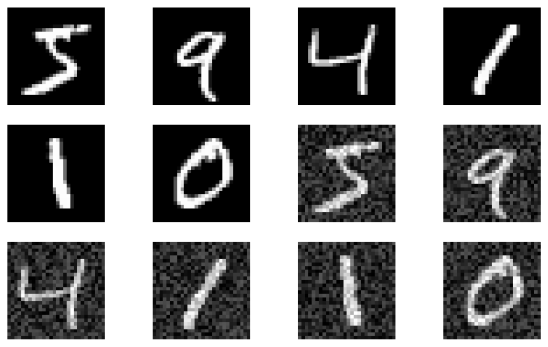

In [11]:
# Pop out the data matrices
img = train_loader.dataset.tensors[0].detach()

# show the numbers
fig,ax = plt.subplots(3,4,figsize=(10,6), dpi=140)

for i,ax in enumerate(ax.flatten()):
    
    ax.imshow(np.reshape(img[i,:],(28,28)) ,cmap='gray')
    ax.axis('off')
    
plt.show()

## 5. Create ANN Model

In [12]:
# create a class for the model
def createTheMNISTNet(LR):

    class MNISTNet(nn.Module):
        
        def __init__(self):
            
            super().__init__()

            ### input layer
            self.input = nn.Linear(784,64)

            ### hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            ### output layer
            self.output = nn.Linear(32,10)

        # forward pass
        def forward(self,x):

            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )

            return self.output(x)
  
    # create the model instance
    ANN_model = MNISTNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=LR)

    return ANN_model,lossfunc,optimizer

## 6. Model Training

In [17]:
def function2trainTheModel(Model , lossfunc , optimizer ,train_loader , devset_loader , epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    devsetAcc  = []
    
    # loop over epochs
    for epochi in range(epochs):
         
        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()                   # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric)       # average and x100 
            batchAcc.append( accuracyPct )                     # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # devset accuracy
        Model.eval()
        X,y = next(iter(devset_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_devset = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        devsetAcc.append( np.round(100*torch.mean((torch.argmax(yHat_devset,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,devsetAcc,losses,Model 

## 7. Parametric Study

In [18]:
# takes ~15 mins

# list of data sample sizes
samplesizes = np.arange(500,5001,500)

# Initialize results matrix : for storing train_acc, test_acc, loss
resultsSingle = np.zeros((len(samplesizes),3))
resultsDouble = np.zeros((len(samplesizes),3))

trained_modelsingle = []
trained_modeldouble = []

for idx,s_size in enumerate(samplesizes):

    ### Without doubling the data!
    ANN_model1,Lossfunc1,Optimizer1 = createTheMNISTNet(LR=0.01)
    
    # generate a dataset and 
    train_loader1,devset_loader1,testdataset1 = makeTheDataset(dataFull=mnist_np, 
                                                               N=s_size, 
                                                               doubleTheData=False)
    
    # train the model : 
    TrainAcc1,DevsetAcc1,Losses1,trained_Model1 = function2trainTheModel(Model=ANN_model1,
                                                        lossfunc=Lossfunc1,
                                                        optimizer=Optimizer1,
                                                        train_loader=train_loader1,
                                                        devset_loader=devset_loader1,
                                                        epochs=50 )
    trained_modelsingle.append(trained_Model1)
    
    # grab the results
    resultsSingle[idx,0] = np.mean(TrainAcc1[-5:])
    resultsSingle[idx,1] = np.mean(DevsetAcc1[-5:])
    resultsSingle[idx,2] = torch.mean(Losses1[-5:]).item()


    ### with doubling the data!
    ANN_model2,Lossfunc2,Optimizer2 = createTheMNISTNet(LR=0.01)
    # generate a dataset and 
    train_loader2,devset_loader2,testdataset2 = makeTheDataset(dataFull=mnist_np,
                                                               N=s_size,
                                                               doubleTheData=True)
   
    # train the model : 
    TrainAcc2,DevsetAcc2,Losses2,trained_Model2= function2trainTheModel(Model=ANN_model2,
                                                        lossfunc=Lossfunc2,
                                                        optimizer=Optimizer2,
                                                        train_loader=train_loader2,
                                                        devset_loader=devset_loader2,
                                                        epochs=50 )
    
    trained_modeldouble.append(trained_Model2)
    
    # grab the results
    resultsDouble[idx,0] = np.mean(TrainAcc2[-5:])
    resultsDouble[idx,1] = np.mean(DevsetAcc2[-5:])
    resultsDouble[idx,2] = torch.mean(Losses2[-5:]).item()

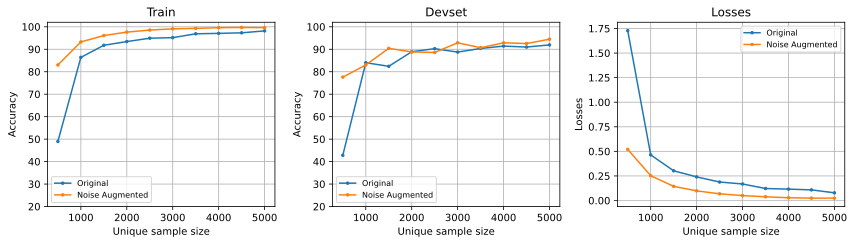

In [20]:
# Let's see what the results look like!

fig,ax = plt.subplots(1,3,figsize=(12,3.5) ,dpi = 140)

# axis and title labels
titles    = ['Train','Devset','Losses']
yaxes_labels = ['Accuracy','Accuracy','Losses']

# common features
for i in range(3):

    # plot the lines
    ax[i].plot(samplesizes,resultsSingle[:,i],'o-',label='Original',markersize =2.5)
    ax[i].plot(samplesizes,resultsDouble[:,i],'o-',label='Noise Augmented',markersize =2.5)

    # make it look nicer
    ax[i].set_ylabel(yaxes_labels[i])
    ax[i].set_title(titles[i])
    ax[i].legend(fontsize = 8)
    ax[i].set_xlabel('Unique sample size')
    ax[i].grid('on')

    if i<2:
        ax[i].set_ylim([20,102])

plt.tight_layout()
plt.show()

In [22]:
X_test_single,y_test_single = testdataset1

In [31]:
X_test_single.shape

torch.Size([65000, 784])

In [32]:
y_test_single.shape

torch.Size([65000])

## Performance on  Test data

In [34]:
model_testacc_single = []
model_testacc_double = []

# Extract X,y from testset
X_test_single,y_test_single = testdataset1 

for Trained_Mod_single in trained_modelsingle:
    
    # Test accuracy
    Trained_Mod_single.eval()
    
    
    with torch.no_grad():         # deactivates autograd
        yHat_test_single = Trained_Mod_single(X_test_single)

    # compare the following really long line of code to the training accuracy lines
    model_testacc_single.append( np.round(100*torch.mean((torch.argmax(yHat_test_single,axis=1)==y_test_single).float()),2 ) )
    # End epochs

    
# Extract X,y from testset
X_test_double,y_test_double = testdataset2

for Trained_Mod_double in trained_modeldouble:

    # Test accuracy
    Trained_Mod_double.eval()   
    
    with torch.no_grad():         # deactivates autograd
        yHat_test_double = Trained_Mod_double(X_test_double)

    # compare the following really long line of code to the training accuracy lines
    model_testacc_double.append( np.round(100*torch.mean((torch.argmax(yHat_test_double,axis=1)==y_test_double).float()),2 ) )
    # End epochs

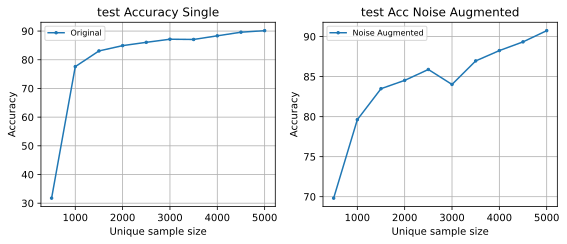

In [39]:
# Let's see what the results look like!

fig,ax = plt.subplots(1,2,figsize=(8,3.5) ,dpi = 140)

# axis and title labels
titles    = ['test Accuracy Single','test Acc Noise Augmented']
yaxes_labels = ['Accuracy','Accuracy',]

# plot the lines
ax[0].plot(samplesizes,model_testacc_single,'o-',label='Original',markersize =2.5)
ax[1].plot(samplesizes,model_testacc_double,'o-',label='Noise Augmented',markersize =2.5)

# make it look nicer
ax[0].set_ylabel('Accuracy')
ax[0].set_title('test Accuracy Single')
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('Unique sample size')
ax[0].grid('on')
                 
# make it look nicer
ax[1].set_ylabel('Accuracy')
ax[1].set_title('test Acc Noise Augmented')
ax[1].legend(fontsize = 8)
ax[1].set_xlabel('Unique sample size')
ax[1].grid('on')


plt.tight_layout()
plt.show()

In [33]:
trained_modelsingle

[MNISTNet(
   (input): Linear(in_features=784, out_features=64, bias=True)
   (fc1): Linear(in_features=64, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=32, bias=True)
   (output): Linear(in_features=32, out_features=10, bias=True)
 ),
 MNISTNet(
   (input): Linear(in_features=784, out_features=64, bias=True)
   (fc1): Linear(in_features=64, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=32, bias=True)
   (output): Linear(in_features=32, out_features=10, bias=True)
 ),
 MNISTNet(
   (input): Linear(in_features=784, out_features=64, bias=True)
   (fc1): Linear(in_features=64, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=32, bias=True)
   (output): Linear(in_features=32, out_features=10, bias=True)
 ),
 MNISTNet(
   (input): Linear(in_features=784, out_features=64, bias=True)
   (fc1): Linear(in_features=64, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=32, bias=True)
   (outp